## Подготовка

### Импорт всех необходимых библиотек

In [2]:
#загружаем библиотеки для работы со структурированными данными и массивами
import pandas as pd
import numpy as np

#загружаем библиотеку для отображения времени выполнения ячейки и времени выполнения кода
import time

#загружаем библиотеку для корректной загрузки датасетов
import os

#загружаем библиотеку для проверки корректности url ссылки
import requests

#загружаем библиотеки для управления уведомлениями
import logging
import warnings

#загружаем классы для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

#загружаем библиотеку для корреляционного анализа
import phik

#загружаем функцию из модуля tsa.seasonal для разложения временного ряда на составляющие
from statsmodels.tsa.seasonal import seasonal_decompose

#загружаем функцию из модуля tsa.stattools для проведения теста на стационарность временного ряда
from statsmodels.tsa.stattools import adfuller

#загружаем функции для проведения автокорреляции и визуализации результатов 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем нужные модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

#загружаем инструменты для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from optuna.integration import OptunaSearchCV
from optuna import distributions

# загружаем функции для работы с метриками
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

Объявляем также константы

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

### Загрузка и изучение данных

Загружаем файл датасета, создаем датафрейм, выводим первые 15 строк и основную информацию для ознакомления. Используем параметр `parse_dates` для того, чтобы сразу явно указать столбец со значениями времени в `read_csv`, который необходимо преобразовать во временной тип данных, также указываем этот же столбец в параметре `index_col`.

In [4]:
#проверяем существование указанной дирректории и в случае возврата True загружаем датасет в переменную, указав верные разделители
pth1 = '/datasets/taxi.csv'
pth2 = 'https://.../datasets/taxi.csv' #часть ссылки скрыта ввиду NDA
pth3 = 'taxi.csv'
if os.path.exists(pth1):
    data_main = pd.read_csv(pth1, sep=',', decimal = '.', parse_dates = ['datetime'], index_col = ['datetime'])
#добавляем проверку корректности url ссылки при помощи requests.get(url) и проверки status_code == 200
elif requests.get(pth2).status_code == 200:
    data_main = pd.read_csv(pth2, sep=',', decimal = '.', parse_dates = ['datetime'], index_col = ['datetime'])
elif os.path.exists(pth3):
    data_main = pd.read_csv(pth3, sep=',', decimal = '.', parse_dates = ['datetime'], index_col = ['datetime'])
else:
    print('Something is wrong')

#выводим первые 15 строк и основную информацию датафрейма    
display(data_main.head(15))
data_main.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Созданный датафрейм:**
- имеет размерность 26496 строк 
- не имеет явные пропуски
- столбцы имеют корректные типы данных
- названия столбцов приведены к змеиному "регистру"
- при первичном ознакомлении неявные дубликаты не выделяются

###  Предобработка данных

Так как датасет состоит всего из двух столбцов, то выделять основные разделы по предобработке данных не будем, а основное опишем в одном небольшом пункте.

Сперва отсортируем датасет по столбцу с индексом, чтобы упорядочить в хронологическом порядке значения

In [5]:
data_main.sort_index(inplace=True)

Сделаем ресемплирование по одному часу

In [6]:
data_main = data_main.resample('1H').sum()

Проверим, что среди значений кол-ва заказов нет аномальных значений

In [7]:
display(round(data_main.describe(),2).T)

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,462.0


Максимальное значение кол-ва заказов, конечно, велико по сравнению с 75 процентилем, но эти выбросы лучше оставить, чтобы модель смогла обучиться лучше на более большом диапазоне значений

**На этапе подготовки данных было проделано следующее:**
- загружен датасет и проведено первичное ознакомление:
   - датасет имеет размерность 26496 строк 
   - не имеет явные пропуски
   - столбцы имеют корректные типы данных
   - названия столбцов приведены к змеиному "регистру"
   - дубликатов не обнаружено
- датасет отсортирован по времени 
- произведено ресемплирование значений по одному часу

## Анализ

Построим график изменения величины  целевого признака с течением времени

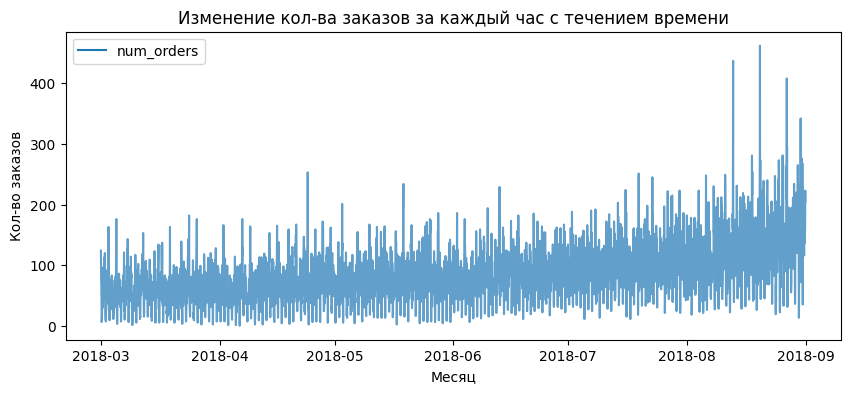

In [8]:
plt.figure(figsize=(10,4))
sns.lineplot(data = data_main, alpha=0.7)
plt.grid(False)
plt.ylabel('Кол-во заказов')
plt.xlabel('Месяц')
plt.title('Изменение кол-ва заказов за каждый час с течением времени')
plt.show()

Из-за ресемплирования данных в 1 час на графике слишком много значений, график не наглядный, построим дополнительно график для ресемплированных данных в 1 неделю

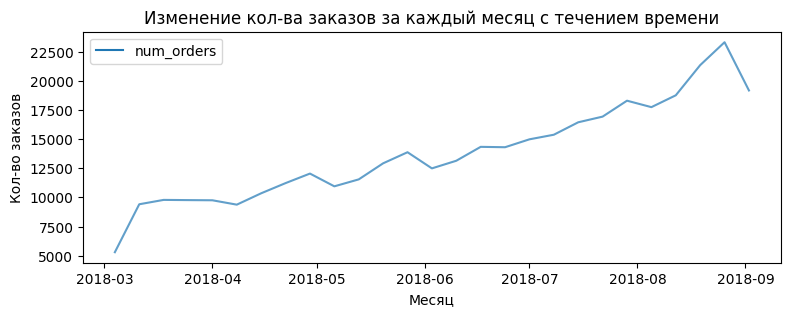

In [9]:
plt.figure(figsize=(9,3))
sns.lineplot(data = data_main.resample('1W').sum(), alpha=0.7)
plt.grid(False)
plt.ylabel('Кол-во заказов')
plt.xlabel('Месяц')
plt.title('Изменение кол-ва заказов за каждый месяц с течением времени')
plt.show()

На таком графике более отчетливо виден положительный тренд увеличения кол-ва заказов с апреля по сентябрь. Для более детального изучения разложим временной ряд на тренд, сезонную компоненту и остатки и построим графики для каждой компоненты при помощи `seasonal_decompose()`. Сезонную составляющую для наглядности возьмем за период в первые две недели нашего временного ряда.

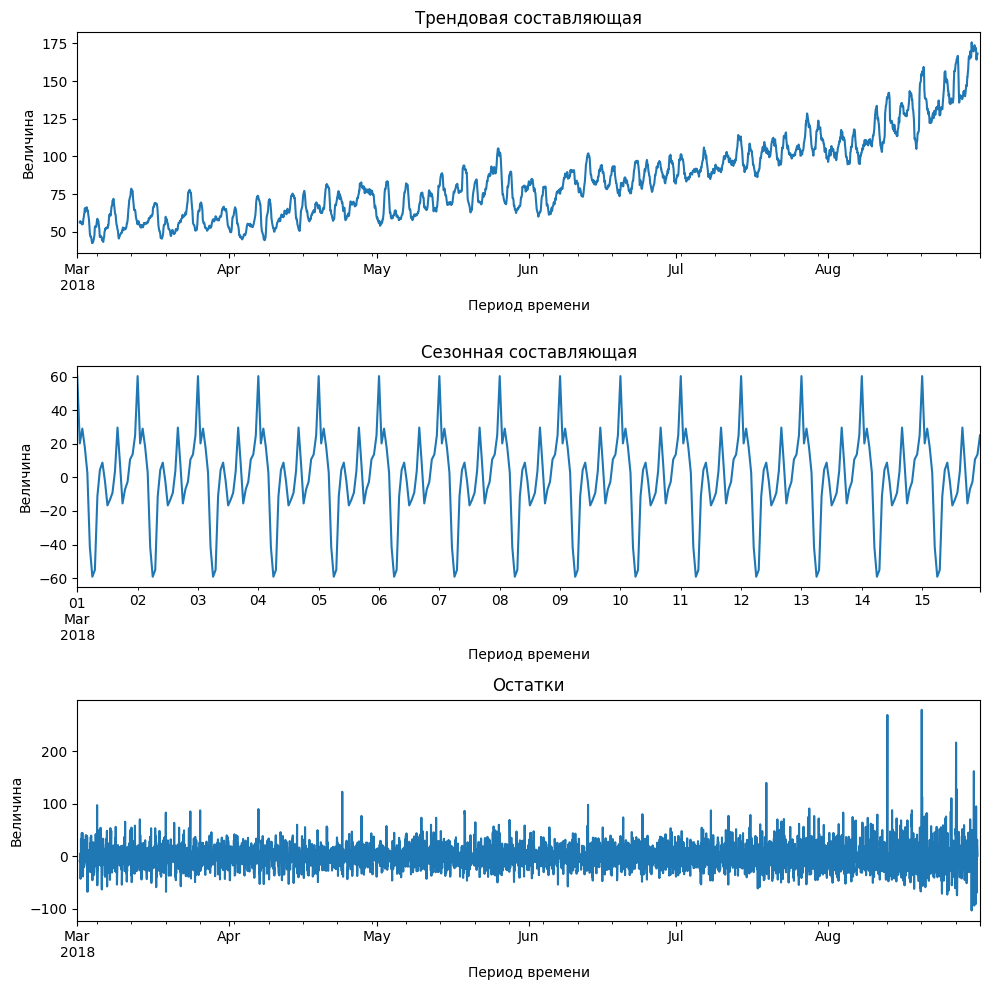

In [10]:
#функция seasonal_decompose() принимает временной ряд, а возвращает объект структуры DecomposeResult
decomposed = seasonal_decompose(data_main)

#строим три графика друг под другом
plt.figure(figsize=(10, 10))

#трендовая составляющая
#чтобы график корректно отобразился, указываем его оси ax, равными plt.gca()
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Трендовая составляющая')
plt.ylabel('Величина')
plt.xlabel('Период времени')

#сезонную составляющую decomposed.seasonal возьмем за первые две недели для наглядности
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.ylabel('Величина')
plt.xlabel('Период времени')

#остатки
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.ylabel('Величина')
plt.xlabel('Период времени')

# для автоматической настройки расположения элементов подписей укажем `plt.tight_layout()`
plt.tight_layout()

Дополнительно построим график сезонности в рамках одних суток по часам

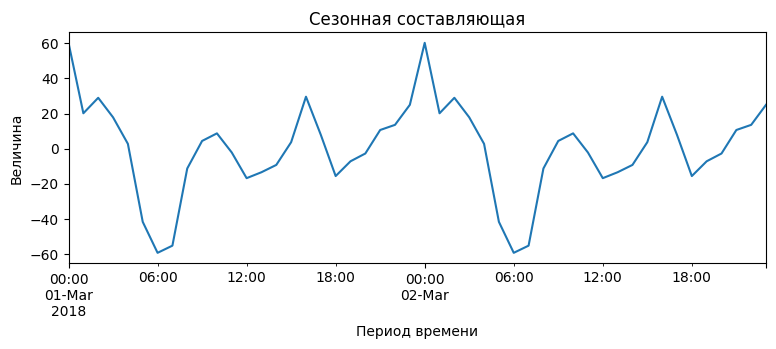

In [11]:
plt.figure(figsize=(9, 3))
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.ylabel('Величина')
plt.xlabel('Период времени')
plt.show()

**Графики показывают следующее:**
- отчетливо виден положительный тренд по увеличению общего кол-ва заказов на всем временном интервале с марта по август с еще большим увеличением кол-ва заказов в летний период. Так как мы рассматриваем данные за пол года, то в этом случае мы рассматриваем это увеличение, как тренд, если бы рассматривали более чем за 1 год и такое увеличение повторялось бы ежегодно, то это уже была бы сезонность.
- график сезонной составляющей по часам показывает, что кол-во заказов такси с полночи до утра уменьшается, с утра до ночи увеличивается, пиковое количество заказов приходится ровно на полночь.
- также по графику сезонной составляющей видна цикличность в 24 часа.
- остатки распределены практически равномерно вокруг нуля. Присутствуют некоторые колебания, которые нам показывают, что есть выбросы с большим количеством заказов.

Дополнительно посмотрим распределение общего количества заказов в час

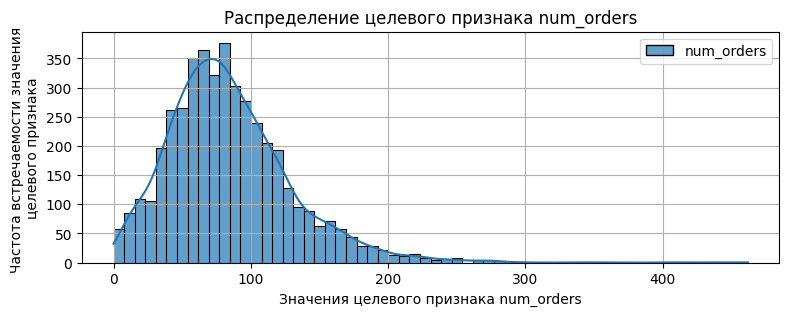

In [12]:
plt.figure(figsize=(9,3))
sns.histplot(data = data_main, bins = 60, kde=True, alpha=0.7)
plt.grid()
plt.ylabel('Частота встречаемости значения \nцелевого признака')
plt.xlabel('Значения целевого признака num_orders')
plt.title('Распределение целевого признака num_orders')
plt.show()

**Из графика видно следующее:**
- чаще всего в час бывает от 60 до 80 заказов
- кол-во заказов свыше 200 в час бывает редко

Дополнительно для проверки временного ряда на стационарность, проведем тест Дики-Фуллера

In [13]:
result = adfuller(data_main['num_orders'], autolag='AIC')

print(f'Критерий ADF: {result[0]}')
print(f'P-значение: {result[1]}')
print(f'Критические значения: ')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1] < 0.05:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924289027944
P-значение: 0.028940051402613857
Критические значения: 
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


Следовательно, наш временной ряд подходит для прогнозирования.

Для оптимального определения количества лагов дополнительно проведем анализ автокорреляции

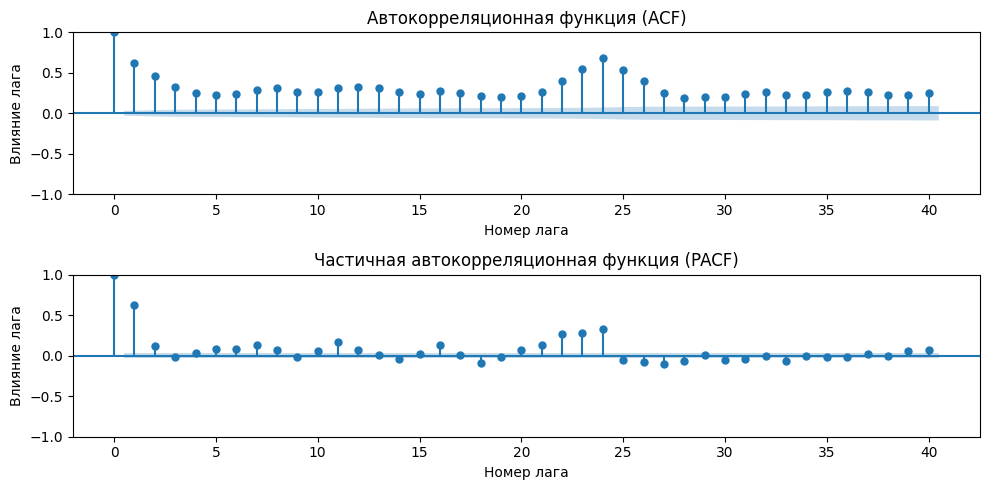

In [14]:
# Автокорреляция (ACF)
acf_result = acf(data_main['num_orders'], nlags=40)

# Частичная автокорреляция (PACF)
pacf_result = pacf(data_main['num_orders'], nlags=40)

#визуализируем функции
plt.figure(figsize=(10, 5))
plt.subplot(211)
plot_acf(data_main['num_orders'], lags=40, ax=plt.gca())
plt.xlabel('Номер лага')
plt.ylabel('Влияние лага')
plt.title('Автокорреляционная функция (ACF)')

plt.subplot(212)
plot_pacf(data_main['num_orders'], lags=40, method='ywm', ax=plt.gca())
plt.xlabel('Номер лага')
plt.ylabel('Влияние лага')
plt.title('Частичная автокорреляционная функция (PACF)')

plt.tight_layout()
plt.show()

По графику автокорреляций видно, что максимальное влияние оказывают 1 и 24 лаги, ограничимся кол-вом лагов в 24

**На этапе анализа данных полученные графики позволили сделать следующие выводы**
- отчетливо виден положительный тренд по увеличению общего кол-ва заказов на всем временном интервале с марта по август с еще большим увеличением кол-ва заказов в летний период. Так как мы рассматриваем данные за пол года, то в этом случае мы рассматриваем это увеличение, как тренд, если бы рассматривали более чем за 1 год и такое увеличение повторялось бы ежегодно, то это уже была бы сезонность.
- график сезонной составляющей показывает, что кол-во заказов такси с ночи до утра уменьшается, с утра до ночи увеличивается, пиковое количество заказов приходится ровно на полночь.
- также по графику сезонной составляющей видна ежедневная цикличность в 24 часа, нам это поможет при создании новых столбцов со сдвигом целевого признака.
- остатки распределены практически равномерно вокруг нуля. Присутствуют некоторые колебания, которые нам показывают, что есть выбросы с большим количеством заказов.
- тест Дики-Фуллера показал, что ряд стационарный
- по графику автокорреляции видно, что максимальное влияние оказывают 1 и 24 лаги.
- чаще всего в час бывает от 60 до 80 заказов
- кол-во заказов свыше 200 в час бывает редко

## Обучение: этап первый

### Создание признаков

Так как у нас из входных признаков имеется только столбец-индекс с временным типом данных, то на первом этапе создадим для обучения модели входные признаки:

-  календарные (месяц, день, день недели)
-  столбцы со сдвигом назад значений целевого признака временного ряда (максимальный сдвигаемый шаг - 24, так как на графике сезонной составляющей мы увидели ежедневную цикличность в 24 часа и по графику автокорреляции максимальное влияние было от 24 лага)
-  столбец со скользящим средним (размер окна 24, равный сезонности, при краткосрочных анализах до года лучше размер окна задать максимальному шагу сдвига), скользящее среднее задаст общий тренд временного ряда
- на втором этапе обучения попробуем добавить столбец с разностью временного ряда

Для создания воспользуемся функцией `make_features`:

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(data_main, 24, 24)

In [16]:
data_main.head(11)

,num_orders,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Признаки созданы, осталось только после разделения на тренировочный и тестовый датасеты удалить строки с пустыми ячейками в начале, которые образовались из-за того, что для них нет исторических данных

### Корреляционный анализ новых признаков

Так как были добавлены новые признаки, то можно взглянуть на матрицу корреляции для более детального изучения взаимосвязи между входными созданными признаками и целевым. Воспользуемся матрицей корреляции `phik`, передав в `interval_cols` наименования  столбцов с непрерывными значениями, чтобы расчеты не уходили в бесконечность

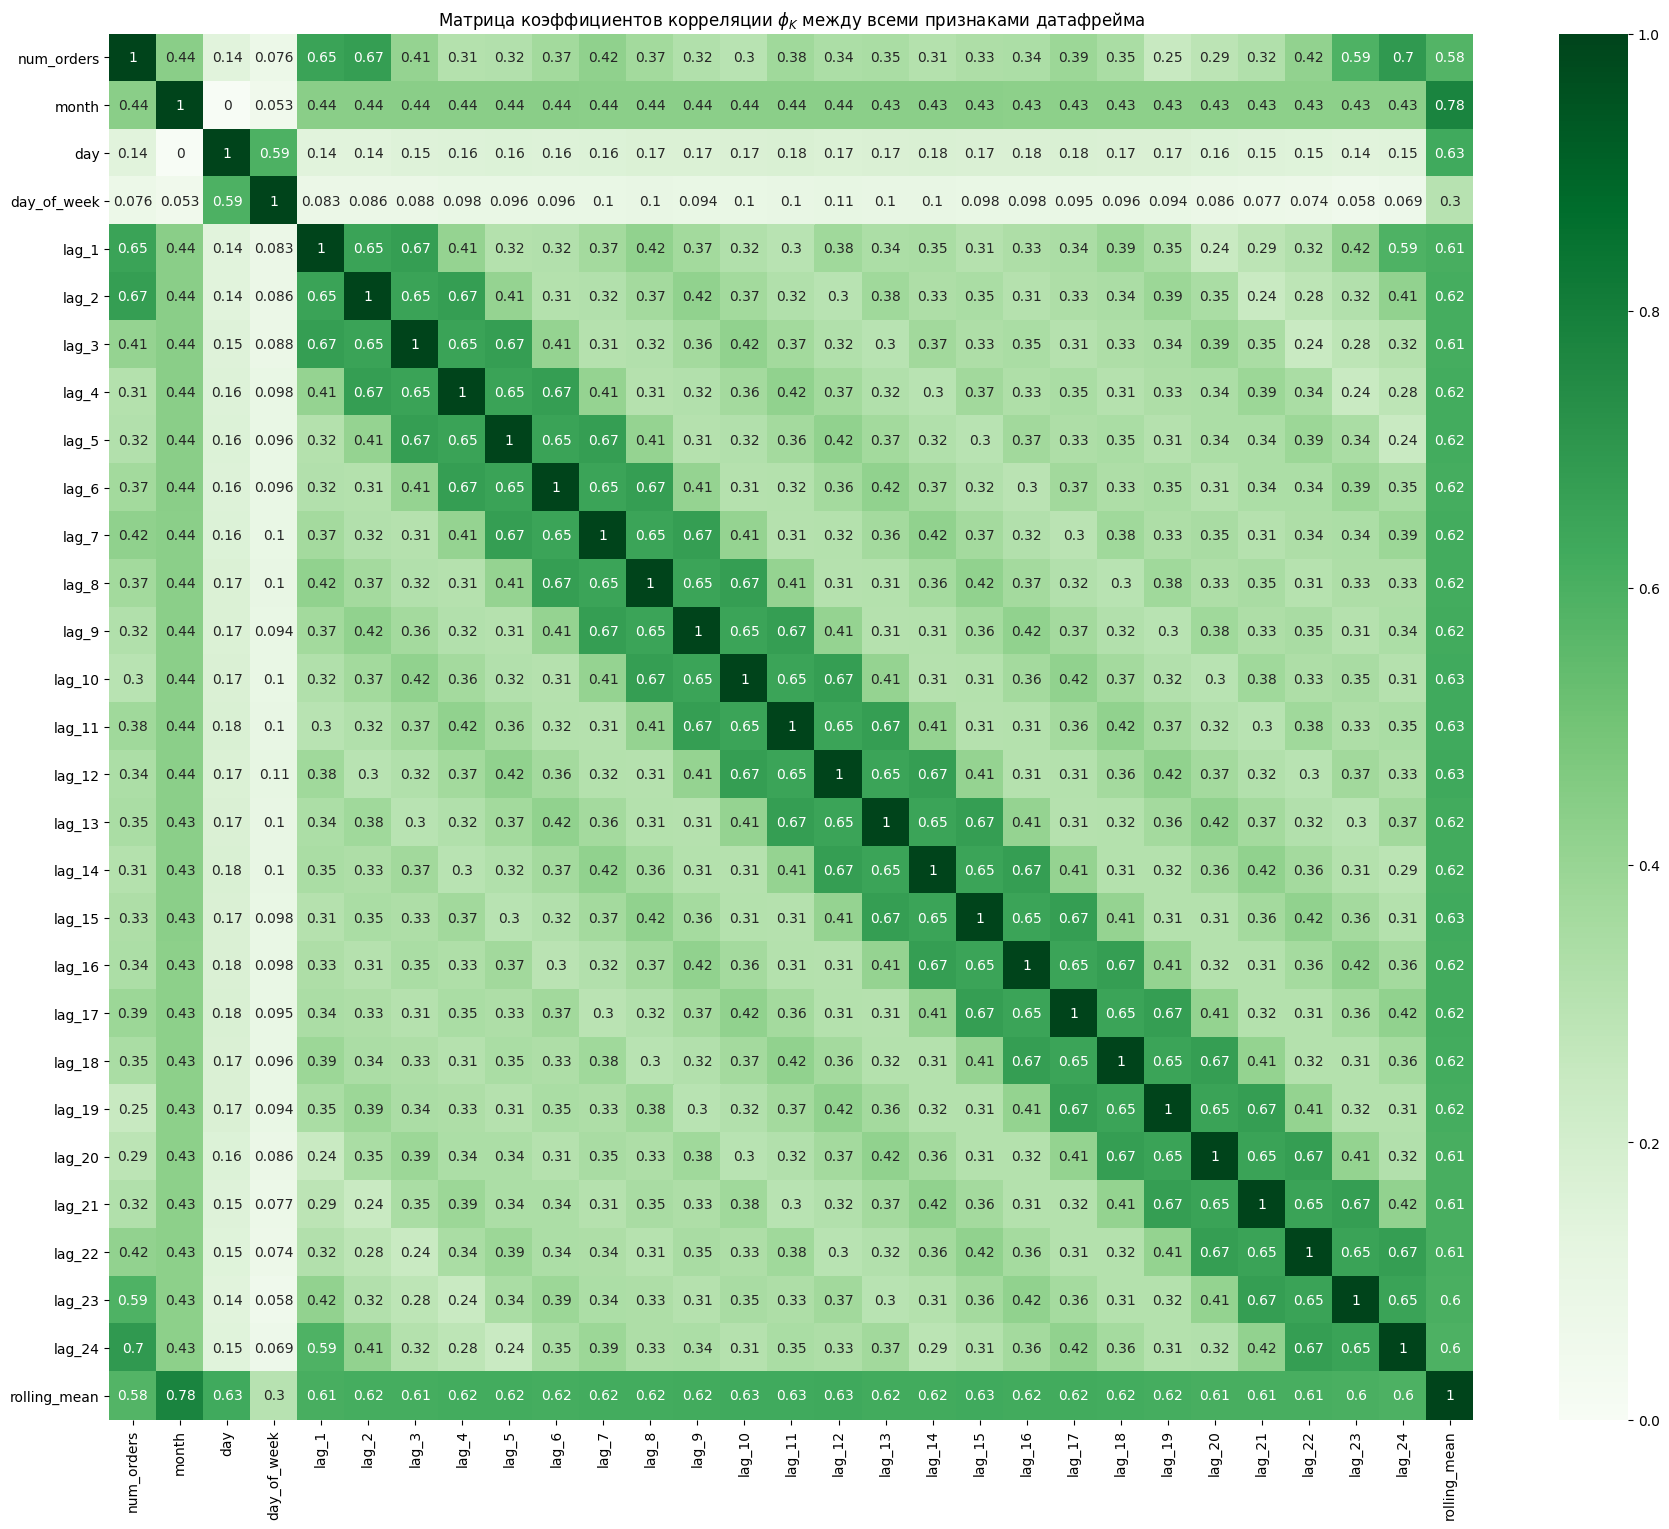

In [17]:
interval_cols = [
    'rolling_mean',
    'num_orders',
    'lag_1',
    'lag_2',
    'lag_3',
    'lag_4',
    'lag_5',
    'lag_6',
    'lag_7',
    'lag_8',
    'lag_9',
    'lag_10',
    'lag_11',
    'lag_12',
    'lag_13',
    'lag_14',
    'lag_15',
    'lag_16',
    'lag_17',
    'lag_18',
    'lag_19',
    'lag_20',
    'lag_21',
    'lag_22',
    'lag_23',
    'lag_24'
]

plt.figure(figsize = (22,18))
sns.heatmap(data_main.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между всеми признаками датафрейма')
plt.show()

**Из полученной матрицы корреляции видно следующее:**
 - самая высокая корреляция между целевым признаком `num_orders` и столбцами со следующими сдвигами значений: 
    - `lag_24` (0.7),
    - `lag_2` (0.67),
    - `lag_1` (0.65),
    - `lag_23` (0.59)
    - и столбцом со скользящим средним `rolling_mean` 0.58
 - из календарных столбцов самая высокая корреляция с целевым признаком у столбца `month` - 0.44, у признака `day_of_week` самая низкая корреляция между всеми входными признаками - 0.076
 - мультиколлинеарности между новыми входными признаками не выявлено

### Разделение на выборки

Разделим датасет на тренировочную и тестовую выборки, размер тестовой выборки должен быть 0.1, укажем параметр `shuffle=False`, чтобы при разбиении на выборки строки не перемешивались и не нарушался наш хронологический порядок. Также после разбиения на тестовую и тренировочную выборку, но перед выделением целевого признака, удалим строки из тренировочной выборки с пустыми значениями, для которых нет исторических данных

In [18]:
train, test = train_test_split(data_main,
                               shuffle=False,
                               test_size = TEST_SIZE,
                               random_state = RANDOM_STATE)
#удаление пустых значений из тренировочной выборки
train = train.dropna()

X_train = train.drop('num_orders', axis =1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis =1)
y_test = test['num_orders']

**Данные разделены на тренировочную и тестовую выборки без перемешивания значений и удалены пустые значения в тренировочной выборке, для которых нет исторических данных**

### Написание функции для расчета RMSE

Напишем свою простую функцию для подсчета этой метрики. Для того, чтобы можно было использовать метрику при кросс-валидации при автоматизированном поиске гиперпараметров, то воспользуемся `make_scorer`. Также укажем параметр `greater_is_better=False`, так как в нашем случае мы пытаемся минимизировать ошибку. Если захотим вывести итоговую таблицу работы всех моделей `cv_results_`, то просто умножим столбец со значением метрики на `-1`, чтобы увидеть реальное значение метрики

In [19]:
def rmse_score(y_real,y_preds):
    return np.sqrt(mean_squared_error(y_real,y_preds))

rmse_score_sv = make_scorer(
    rmse_score,
    greater_is_better=False
)

**Создана собственная функция для подсчета метрики RMSE и для использования ее при автоматизированном подборе гиперпараметров**

### Обучение моделей

В нашем исследовании будем использовать несколько моделей: 
 - KNeighborsRegressor(), 
 - DecisionTreeRegressor(), 
 - LinearRegressor(),
 - CatBoostRegressor(),
 - LGBMRegressor(). 

Так как модели бустинга обучаются долго, особенно долго обучается LGBMRegressor(), то у нее возьмем один набор гиперпараметров, а у модели  CatBoostRegressor() тоже добавим небольшой диапазон значений только в одном гиперпараметре. Так как у моделей бустинга будет мало гиперпараметров, то для них и моделей KNeighborsRegressor() и LinearRegressor(), обучающихся довольно быстро, для наилучшего результата будем использовать GridSearchCV(), а для модели DecisionTreeRegressor(), для которой мы зададим большое количество диапазонов гиперпараметров, используем OptunaSearchCV() для получения более лучшего результата и более быстрого в сравнении с RandomizedSearchCV() с большим количеством итераций. При обучении модели DecisionTreeRegressor() подготовим данные вручную, так как нет категориальных признаков и это не займет много времени. При обучении 4 остальных моделей  для удобства будем использовать пайплайн. Итоговые результаты по качеству и времени работы моделей получим из таблиц `cv_results_` и `oscv.trials_dataframe()`.

#### Модель DecisionTreeRegressor() 

Так как при использовании GridSearchCV() при подборе широких диапазонов гиперпараметров вычисления занимают очень много времени, то воспользуемся инструментом OptunaSearchCV, который подберет гиперпараметры в десятки раз быстрее в сравнении с RandomizedSearchCV() с большим кол-вом итераций.

Сначала масштабируем все наши входные признаки

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#присваиваем названия столбцов в соответсвии с нашим датафреймом
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns.to_list())

Задаем диапазоны гиперпараметров для корректной работы Optuna через `distributions.IntDistribution()`, также отключаем уведомления при подборе гиперпараметров, оставляем только предупреждения о критических ошибках

In [21]:
#отключение уведомлений от Optuna о ходе выполнения работы, оставляем только уведомления о критических ошибках
logging.getLogger("optuna").setLevel(logging.ERROR)

#отключаем ExperimentalWarning от optuna, в конце блока восстановим настройки по умолчанию для уведомлений
warnings.filterwarnings('ignore')

# запускаем таймер
start = time.time()

parameters = {
    'max_depth': distributions.IntDistribution(2, 16),
    'min_samples_split': distributions.IntDistribution(2,12),
    'min_samples_leaf': distributions.IntDistribution(1, 12),
    'max_features': distributions.IntDistribution(1, 12)
}

oscv = OptunaSearchCV(
        DecisionTreeRegressor(random_state=RANDOM_STATE),
        parameters,
        cv=5,
        scoring=rmse_score_sv,
        n_trials = 50,
        random_state=RANDOM_STATE
)

# поиск гиперпараметров
oscv = oscv.fit(X_train_scaled,y_train)

# считаем, сколько секунд прошло с начала запуска
oscv_search_time = time.time() - start
print(f'Время поиска:{oscv_search_time}')

# восстанавливает настройки по умолчанию для уведомлений
warnings.resetwarnings() 

#лучшие гиперпараметры
print('\nЛучший набор гиперпараметров:', oscv.best_params_)
#лучшая метрика качества
print(f'\nМетрика RMSE при кросс-валидации у лучшей модели составила {-oscv.best_score_:.2f}')

Время поиска:3.838360071182251

Лучший набор гиперпараметров: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 12}

Метрика RMSE при кросс-валидации у лучшей модели составила 28.53


Дополнительно выведем все показатели лучшей модели

In [22]:
display(oscv.trials_dataframe().sort_values(by='value', ascending=False).iloc[:1][['value',
                                                                                   'user_attrs_mean_fit_time',
                                                                                   'user_attrs_mean_score_time',
                                                                                   'params_max_depth',
                                                                                   'params_min_samples_split',
                                                                                   'params_min_samples_leaf',
                                                                                   'params_max_features'
                                                                                  ]])

,value,user_attrs_mean_fit_time,user_attrs_mean_score_time,params_max_depth,params_min_samples_split,params_min_samples_leaf,params_max_features
31,-28.53187,0.012899,0.001403,7,3,11,12


Лучшие гиперпараметры для модели DecisionTreeRegressor() были подобраны за 3.84 секунды и оказались следующими:
 - *'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 12*
 
Основные показатели получились следующими:
 - **метрика RMSE при кросс-валидации составила 28.53**
 - среднее время обучения 0.013 секунды
 - среднее время прогноза и оценивания 0.0012 секунды

#### Модели KNeighborsRegressor(),  LinearRegressor(),  CatBoostRegressor() и LGBMRegressor()

Для обучения всех остальных моделей для удобства создадим общий пайплайн. Так как модели бустинга обучаются долго, особенно долго обучается LGBMRegressor(), то у нее возьмем один набор гиперпараметров, а у модели  CatBoostRegressor() тоже добавим небольшой диапазон значений только в одном гиперпараметре. Так как у нас только количественные признаки, то шаг препроцессинга будет состоять только  из масштабирования признаков разными скейлерами - StandardScaler() и MaxMinScaler(). Так как KNeighborsRegressor() и LinearRegressor() обучаются быстро, то для получения полноценного результата для автоматизированного подбора гиперпараметров будем использовать GridSearchCV(). Итоговые результаты по качеству и времени работы моделей получим из таблицы `cv_results_`.

Сначала создадим список из наименований всех входных признаков, которые мы будем масштабировать.

In [23]:
num_columns = [ 'month',
                'day',
                'day_of_week',
                'lag_1',
                'lag_2',
                'lag_3',
                'lag_4',
                'lag_5',
                'lag_6',
                'lag_7',
                'lag_8',
                'lag_9',
                'lag_10',
                'lag_11',
                'lag_12',
                'lag_13',
                'lag_14',
                'lag_15',
                'lag_16',
                'lag_17',
                'lag_18',
                'lag_19',
                'lag_20',
                'lag_21',
                'lag_22',
                'lag_23',
                'lag_24',
                'rolling_mean'
              ] 

Создадим общий пайплайн для предобработки данных, включающий только масштабирование данных.

In [24]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['month', 'day', 'day_of_week', 'lag_1',
                                  'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
                                  'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
                                  'lag_12', 'lag_13', 'lag_14', 'lag_15',
                                  'lag_16', 'lag_17', 'lag_18', 'lag_19',
                                  'lag_20', 'lag_21', 'lag_22', 'lag_23',
                                  'lag_24', 'rolling_mean'])])


Соберем наш итоговый пайплайн. У модели LinearRegression() зададим несколько типов масштабирования - StandardScaler(), MinMaxScaler() и вариант без масштабирования. У KNeighborsRegressor() добавим вариант без масштабирования. У CatBoostRegressor() оставим количество деревьев - 1200. Для наилучшего результата будем использовать GridSearchCV()

In [25]:
pipe_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__fit_intercept': [True,False],
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(verbose = 0, 
                                     loss_function = 'RMSE',
                                     depth = 6,
                                     random_seed = RANDOM_STATE)
                  ],
        'models__learning_rate': [0.03, 0.1],
        'models__iterations': [1200],
        'preprocessor__num': [StandardScaler()]
    },
    #словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(verbose = -1, 
                                n_estimators = 200, 
                                 num_leaves = 25, 
                                 learning_rate=0.1, 
                                 metric='rmse',
                                 force_col_wise = True,
                                 max_depth = 5,
                                 random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler()]
    }
]

# запускаем таймер для проверки длительности поиска при GridSearchCV
start = time.time()

grid_search = GridSearchCV(
    pipe_one, 
    param_grid=param_grid, 
    cv=5, 
    scoring= rmse_score_sv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('Характеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')


print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика RMSE для лучшей модели, полученная при кросс-валидации:', abs(grid_search.best_score_))

Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 16.755143404006958
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'day_of_week', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
     

Лучшей моделью оказалась CatBoostRegressor() с метрикой RMSE = 23.3. Пробовал также вариант с полиномизацией признаков, но расчеты увеличились в 7 раз, а метрика ухудшилась, поэтому остаемся на этом результате. Посмотрим таблицу результатов для лучших 10 моделей

In [26]:
#устанавливаем настройки, чтобы таблица с результатами отображалась полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#получаем таблицу с работой всех моделей
result_models_rate = pd.DataFrame(grid_search.cv_results_)

#для корректного отображения среднего значения метрики RMSE умножаем столбец на -1 
result_models_rate[
    'mean_test_score'
] = result_models_rate['mean_test_score'] * -1

result_models_rate = result_models_rate.sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_rate[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
50,1,<catboost.core.CatBoostRegressor object at 0x000001F403E59460>,23.300442,3.314881,0.006673,"{'models': <catboost.core.CatBoostRegressor object at 0x000001F403E59460>, 'models__iterations': 1200, 'models__learning_rate': 0.03, 'preprocessor__num': StandardScaler()}"
51,2,<catboost.core.CatBoostRegressor object at 0x000001F403E59460>,23.706400,3.040726,0.006332,"{'models': <catboost.core.CatBoostRegressor object at 0x000001F403E59460>, 'models__iterations': 1200, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
52,3,"LGBMRegressor(force_col_wise=True, max_depth=5, metric='rmse', n_estimators=200,\n num_leaves=25, random_state=42, verbose=-1)",24.169305,0.540815,0.007424,"{'models': LGBMRegressor(force_col_wise=True, max_depth=5, metric='rmse', n_estimators=200, num_leaves=25, random_state=42, verbose=-1), 'preprocessor__num': StandardScaler()}"
24,4,KNeighborsRegressor(),24.243911,0.010316,0.029206,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 14, 'preprocessor__num': StandardScaler()}"
22,5,KNeighborsRegressor(),24.275019,0.009827,0.030011,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 13, 'preprocessor__num': StandardScaler()}"
18,6,KNeighborsRegressor(),24.303840,0.009714,0.029986,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 11, 'preprocessor__num': StandardScaler()}"
16,7,KNeighborsRegressor(),24.346443,0.010479,0.030504,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 10, 'preprocessor__num': StandardScaler()}"
20,8,KNeighborsRegressor(),24.353280,0.009570,0.024734,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 12, 'preprocessor__num': StandardScaler()}"
14,9,KNeighborsRegressor(),24.358113,0.007622,0.025652,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 9, 'preprocessor__num': StandardScaler()}"
12,10,KNeighborsRegressor(),24.545642,0.010203,0.030842,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 8, 'preprocessor__num': StandardScaler()}"


**Из полученных результатов видно следующее:**
 - **лучшей моделью оказалась модель CatBoostRegressor(iterations = 1200, learning_rate = 0.03, depth = 6, StandardScaler()), среднее время обучения составило 3.315 секунды, а среднее время оценки и прогноза модели составило 0.007 секунды**
 - **метрика RMSE лучшей модели при кросс-валидации составила 23.3**
 - на втором месте оказалась модель LGBMRegressor() со стандартным набором гиперпараметров, метрика у нее оказалась немного хуже, чем у модели CatBoostRegressor(), а время обучения оказалось намного меньше - 0.54 секунды, прогнозное время оказалось 0.0074 сек.
 - лучшая из моделей KNeighborsRegressor() оказалась на 3 месте из всех моделей, метрика RMSE -  24.24, но зато время обучения составило всего 0.001 секунды. Зато время прогнозирования и оценивания у CatBoostRegressor() в разы быстрее, чем у модели ближних соседей, а этот параметр важнее обучения.
 - модель DecisionTreeRegressor() показала худшую метрику при кросс-валидации среди всех моделей - 28.53 секунды.

### Анализ важности признаков модели CatBoostRegressor()

Теперь взглянем на коэффициенты важности признаков, рассчитанные моделью

In [27]:
#создаем датафрейм для значений важности и наименований каждого столбца
feature_importances_regressor = pd.DataFrame(
    {
        'Входные признаки': grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
        'Важность': round(pd.Series(grid_search.best_estimator_.named_steps['models'].feature_importances_),2)
    })

Визуализируем рассчитанные моделью коэффициенты важности признаков

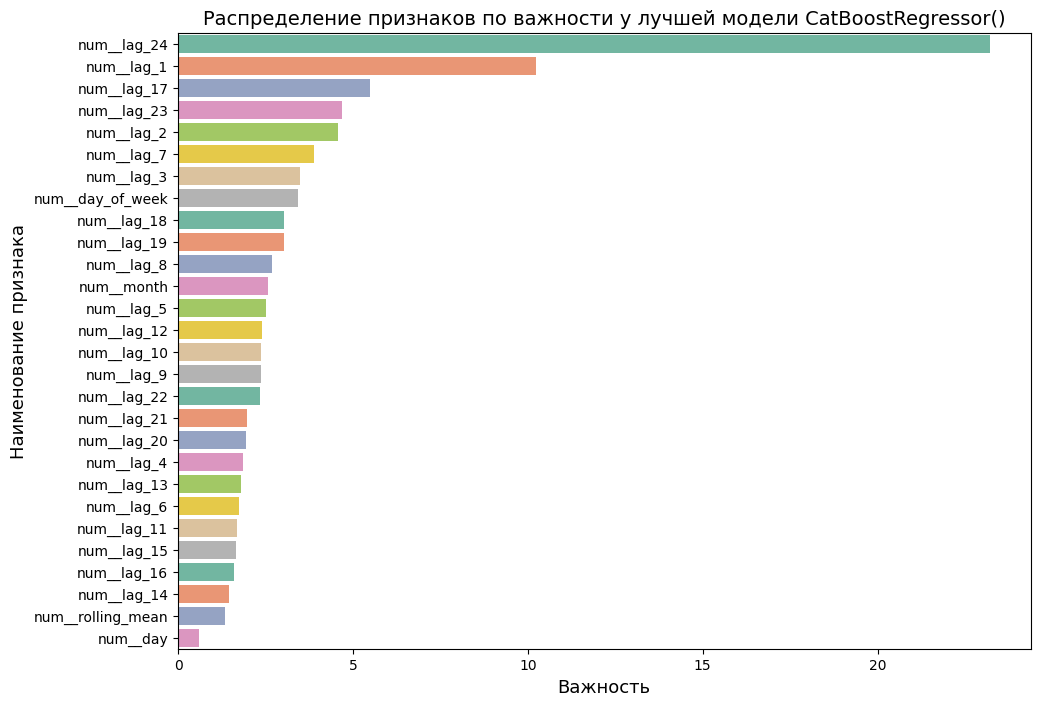

In [28]:
#рисуем график важности признаков
plt.figure(figsize=(11, 8))
sns.barplot(x = 'Важность', y = 'Входные признаки' , data = feature_importances_regressor.\
                         sort_values(by='Важность', ascending = False), palette = 'Set2')


plt.xlabel('Важность', fontsize = 13)
plt.ylabel('Наименование признака', fontsize = 13)
plt.title('Распределение признаков по важности у лучшей модели CatBoostRegressor()', fontsize = 14)
plt.show()

**Полученный график показывает следующее:**
- прогнозируемая моделью величина кол-ва заказов больше всего зависит от столбца `lag_24`, в котором находятся смещенные на 24 шага назад значения из столбца с целевым признаком
- второе место по важности занимает столбец с признаком `lag_1`
- из столбцов с календарными признаками наибольшую важность занимает столбец `day_of_week`
- столбец со скользящим средним `rolling_mean` занимает предпоследнее место по важности признаков
- наименее важный признак - столбец с календарным признаком `day`

**На первом этапе обучения моделей было сделано следующее следующее:**

- *Для обучения модели были созданы следующие входные признаки:*
   -  календарные (месяц, день, день недели)
   -  столбцы со сдвигом назад значений целевого признака временного ряда (максимальный сдвигаемый шаг - 24)
   -  столбец со скользящим средним (размер окна 24), так как скользящее среднее задает общий тренд временного ряда

- *Для новых входных признаков построена матрица корреляции для понимания влияния на целевой признак. Из полученной матрицы корреляции видно следующее:*
  - самая высокая корреляция между целевым признаком `num_orders` и столбцами со следующими сдвигами значений: 
     - `lag_24` (0.7),
     - `lag_2` (0.67),
     - `lag_1` (0.65),
     - `lag_23` (0.59)
     - и столбцом со скользящим средним `rolling_mean` 0.58
  - из календарных столбцов самая высокая корреляция с целевым признаком у столбца `month` - 0.44, у признака `day_of_week` самая низкая корреляция между всеми входными признаками - 0.076
  - мультиколлинеарности между новыми входными признаками не выявлено
   
- данные разделены на тренировочную и тестовую выборки без перемешивания значений и удалены пустые значения в тренировочной выборке, для которых нет исторических данных
- для оценивания качества работы моделей была созданна функция для расчета метрики RMSE, которая при помощи `make_scorer` была применена при автоматизированном поиске гиперпараметров

**Были обучены и подобраны гиперпараметры для пяти моделей:**
- *DecisionTreeRegressor():*
   - данные были масштабированы при помощи StandardScaler(), а лучшие гиперпараметры были подобраны при помощи OptunaSearchCV() за 4.91 секунды
   - лучшие гиперпараметры оказались следующими: *'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 12*
   - основные показатели получились следующими:
    - метрика RMSE при кросс-валидации составила 28.53 и оказалась худшей среди всех моделей
    - среднее время обучения 0.013 секунды
    - среднее время прогноза и оценивания 0.0014 секунды
   
- *KNeighborsRegressor(),*
- *LinearRegressor(),*
- *CatBoostRegressor(),*
- *LGBMRegressor():*
  - для этих четырех моделей для удобства подбора гиперпараметров был составлен общий пайплайн, включающий:
    - подготовку данных: масштабирование количественных признаков при помощи StandardScaler() и MinMaxScaler()
    - перебор гиперпараметров для моделей со словарями их гиперпараметров при помощи инструмента автоматизированного подбора GridSearchCV()
-полученные результаты при подборе гиперпараметров для этих 4 моделей позволили сделать следующие выводы:
- **лучшей моделью оказалась модель CatBoostRegressor(iterations = 1200, learning_rate = 0.03, depth = 6, StandardScaler()), среднее время обучения составило 3.315 секунды, а среднее время оценки и прогноза модели составило 0.007 секунды**
- **метрика RMSE лучшей модели при кросс-валидации составила 23.3**
- на втором месте оказалась модель LGBMRegressor() со стандартным набором гиперпараметров, метрика у нее оказалась немного хуже, чем у модели CatBoostRegressor(), а время обучения оказалось намного меньше - 0.54 секунды, прогнозное время оказалось 0.0074 сек.
- лучшая из моделей KNeighborsRegressor() оказалась на 3 месте из всех моделей, метрика RMSE -  24.24, но зато время обучения составило всего 0.001 секунды. Зато время прогнозирования и оценивания у CatBoostRegressor() в разы быстрее, чем у модели ближних соседей, а этот параметр важнее обучения.
- модель DecisionTreeRegressor() показала худшую метрику при кросс-валидации среди всех моделей - 28.53 секунды.
    
**Полученный график важности признаков лучшей модели первого этапа обучения CatBoostRegressor() показал следующее:**
- прогнозируемая моделью величина кол-ва заказов больше всего зависит от столбца `lag_24`, в котором находятся смещенные на 24 шага назад значения из столбца с целевым признаком
- второе место по важности занимает столбец с признаком `lag_1`
- из столбцов с календарными признаками наибольшую важность занимает столбец `day_of_week`
- столбец со скользящим средним `rolling_mean` занимает предпоследнее место по важности признаков
- наименее важный признак - столбец с календарным признаком `day`

## Обучение: этап второй

### Добавление столбца с разностью временного ряда

На втором этапе обучения в качестве эксперимента добавим новый столбец с разностью временного ряда, чтобы сделать временной ряд более стационарным.

Создадим копию нашего датафрейма, чтобы не затрагивать основной и добавим в него столбец с разностью временного ряда в один шаг

In [29]:
data_trial = data_main.copy()

data_trial['date_diff'] = data_trial['num_orders'] - data_trial['num_orders'].shift()

Разделим данные на тренировочную и тестовую выборку также без перемешивания

In [30]:
train_trial, test_trial = train_test_split(data_trial,
                               shuffle=False,
                               test_size = TEST_SIZE,
                               random_state = RANDOM_STATE)

#удаление пустых значений из тренировочной выборки
train_trial = train_trial.dropna()

X_train_trial = train_trial.drop('num_orders', axis =1)
y_train_trial = train_trial['num_orders']
X_test_trial = test_trial.drop('num_orders', axis =1)
y_test_trial = test_trial['num_orders']

#### Повторное обучение моделей

Повторно обучим все наши модели такими же способами, чтобы повторить последовательность действий

Сначала масштабируем данные для обучения модели DecisionTreeRegressor(). Поиск гиперапараметров также произведем при помощи OptunaSearchCV().

In [31]:
scaler = StandardScaler()
X_train_trial_scaled = scaler.fit_transform(X_train_trial)
X_test_trial_scaled = scaler.transform(X_test_trial)

#присваиваем названия столбцов в соответсвии с нашим датафреймом
X_train_trial_scaled = pd.DataFrame(X_train_trial_scaled, columns=X_train_trial.columns.to_list())
X_test_trial_scaled = pd.DataFrame(X_test_trial_scaled, columns=X_test_trial.columns.to_list())

In [32]:
#отключение уведомлений от Optuna о ходе выполнения работы, оставляем только уведомления о критических ошибках
logging.getLogger("optuna").setLevel(logging.ERROR)

#отключаем ExperimentalWarning от optuna, в конце блока восстановим настройки по умолчанию для уведомлений
warnings.filterwarnings('ignore')

# запускаем таймер
start = time.time()

parameters_trial = {
    'max_depth': distributions.IntDistribution(2, 16),
    'min_samples_split': distributions.IntDistribution(2,12),
    'min_samples_leaf': distributions.IntDistribution(1, 12),
    'max_features': distributions.IntDistribution(1, 12)
}

oscv_trial = OptunaSearchCV(
        DecisionTreeRegressor(random_state=RANDOM_STATE),
        parameters_trial,
        cv=5,
        scoring=rmse_score_sv,
        n_trials = 50,
        random_state=RANDOM_STATE
)

#поиск гиперпараметров
oscv_trial = oscv_trial.fit(X_train_trial_scaled,y_train_trial)

# считаем, сколько секунд прошло с начала запуска
oscv_search_time_trial = time.time() - start
print(f'Время поиска:{oscv_search_time_trial}')

# восстанавливает настройки по умолчанию для уведомлений
warnings.resetwarnings() 

#лучшие гиперпараметры
print('\nЛучший набор гиперпараметров:', oscv_trial.best_params_)
#лучшая метрика качества
print(f'\nМетрика RMSE при кросс-валидации у лучшей модели составила {-oscv_trial.best_score_:.2f}')

Время поиска:4.76510214805603

Лучший набор гиперпараметров: {'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 12}

Метрика RMSE при кросс-валидации у лучшей модели составила 17.46


**Метрика RMSE при кросс-валидации у модели DecisionTreeRegressor() улучшилась с 28.80 до 17.46. Время подбора гиперпараметров увеличилось с 3 секунд до 4.8 секунды. Лучший набор гиперпараметров оказался следующим: 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 12**

Теперь проверим насколько улучшатся результаты остальных моделей при обучении в пайплайне. Поиск гиперпараметров также осуществим через GridSearchCV(). 

Создадим переменную с со всеми количественными столбцами датафрейма для масштабирования, куда добавим столбец с разностью временного ряда 'date_diff'

In [33]:
num_columns_trial = [ 'month',
                'day',
                'day_of_week',
                'lag_1',
                'lag_2',
                'lag_3',
                'lag_4',
                'lag_5',
                'lag_6',
                'lag_7',
                'lag_8',
                'lag_9',
                'lag_10',
                'lag_11',
                'lag_12',
                'lag_13',
                'lag_14',
                'lag_15',
                'lag_16',
                'lag_17',
                'lag_18',
                'lag_19',
                'lag_20',
                'lag_21',
                'lag_22',
                'lag_23',
                'lag_24',
                'rolling_mean',
                'date_diff',
              ] 

Пересоздадим общий пайплайн и посмотрим как изменятся результаты по сравнению с тем, когда в датафреме не было столбца с разностью временного ряда.

In [34]:
# создаём общий пайплайн для подготовки данных
data_preprocessor_trial = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns_trial)
    ], 
    remainder='passthrough'
)

pipe_trial = Pipeline([
    ('preprocessor', data_preprocessor_trial),
    ('models', LinearRegression())
])

param_grid_trial = [
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(verbose = 0, 
                                     loss_function = 'RMSE',
                                     depth = 6,
                                     random_seed = RANDOM_STATE)
                  ],
        'models__learning_rate': [0.03, 0.1],
        'models__iterations': [1200],
        'preprocessor__num': [StandardScaler()]
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(verbose = -1, 
                                n_estimators = 200, 
                                 num_leaves = 25, 
                                 learning_rate=0.1, 
                                 metric='rmse',
                                 force_col_wise = True,
                                 max_depth = 5,
                                 random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler()]
    }
]

# запускаем таймер для проверки длительности поиска при GridSearchCV
start = time.time()

grid_search_trial = GridSearchCV(
    pipe_trial, 
    param_grid=param_grid_trial, 
    cv=5, 
    scoring= rmse_score_sv,
    n_jobs=-1
)
grid_search_trial.fit(X_train_trial, y_train_trial) 

grid_search_time_trial = time.time() - start
print('Характеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time_trial}')


print('Лучшая модель и её параметры:\n\n', grid_search_trial.best_estimator_)
print ('Метрика RMSE для лучшей модели, полученная при кросс-валидации:', abs(grid_search_trial.best_score_))

Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 13.868426084518433
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'day_of_week', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
     

**Получен очень интересный результат. Метрика RMSE при кросс-валидации с добавленным столбцом с разностью временного ряда получилась 4.155192016764669e-14, практически равна 0, прогнозные значения совпали с целевыми, метрика отличается от нуля только по причине того, что в целевом признаке целочисленные значения, а в прогнозе значения с плавающей точкой. Получается, благодаря добавлению столбца `date_diff` и приведению временного ряда к более стационарному, удалось настолько улучшить метрику RMSE, что она стала практически равна 0**

Взглянем на таблицу с лучшими результатами моделей.

In [35]:
#устанавливаем настройки, чтобы таблица с результатами отображалась полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#получаем таблицу с работой всех моделей
result_models_rate_trial = pd.DataFrame(grid_search_trial.cv_results_)

#для корректного отображения среднего значения метрики RMSE умножаем столбец на -1 
result_models_rate_trial[
    'mean_test_score'
] = result_models_rate_trial['mean_test_score'] * -1

result_models_rate_trial = result_models_rate_trial.sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 10 лучших моделей
display(result_models_rate_trial[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(13))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
30,1,LinearRegression(),4.155192e-14,0.012996,0.004602,"{'models': LinearRegression(), 'models__copy_X': False, 'models__positive': True, 'preprocessor__num': StandardScaler()}"
26,1,LinearRegression(),4.155192e-14,0.013411,0.004898,"{'models': LinearRegression(), 'models__copy_X': True, 'models__positive': True, 'preprocessor__num': StandardScaler()}"
27,3,LinearRegression(),7.741632e-14,0.008607,0.003002,"{'models': LinearRegression(), 'models__copy_X': True, 'models__positive': True, 'preprocessor__num': 'passthrough'}"
31,3,LinearRegression(),7.741632e-14,0.007597,0.002801,"{'models': LinearRegression(), 'models__copy_X': False, 'models__positive': True, 'preprocessor__num': 'passthrough'}"
33,5,LinearRegression(),8.446712e-14,0.007917,0.002641,"{'models': LinearRegression(), 'models__copy_X': False, 'models__positive': False, 'preprocessor__num': 'passthrough'}"
29,5,LinearRegression(),8.446712e-14,0.009397,0.003203,"{'models': LinearRegression(), 'models__copy_X': True, 'models__positive': False, 'preprocessor__num': 'passthrough'}"
32,7,LinearRegression(),1.016329e-13,0.012397,0.004819,"{'models': LinearRegression(), 'models__copy_X': False, 'models__positive': False, 'preprocessor__num': StandardScaler()}"
28,7,LinearRegression(),1.016329e-13,0.015420,0.005508,"{'models': LinearRegression(), 'models__copy_X': True, 'models__positive': False, 'preprocessor__num': StandardScaler()}"
34,9,<catboost.core.CatBoostRegressor object at 0x000001F40402F640>,3.951258e+00,12.063377,0.009608,"{'models': <catboost.core.CatBoostRegressor object at 0x000001F40402F640>, 'models__iterations': 1200, 'models__learning_rate': 0.03, 'preprocessor__num': StandardScaler()}"
35,10,<catboost.core.CatBoostRegressor object at 0x000001F40402F640>,4.006100e+00,12.035189,0.008269,"{'models': <catboost.core.CatBoostRegressor object at 0x000001F40402F640>, 'models__iterations': 1200, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"


Полученная таблица с результатами лучших моделей после добавления в датафрейм столбца с разностью временного ряда позволяет сделать следующие выводы:
  - ***Модель LinearRegression() при разных наборах гиперпарметров показала лучший результат на втором этапе обучения среди всех моделей:***
   - ***метрика RMSE*** после добавления столбца с разностью временного ряда `date_diff` у лучшей модели LinearRegression() ***составила 4.155192e-14***, практически равна 0, прогноз был абсолютно точен, метрика отличается от нуля только по причине того, что в целевом признаке целочисленные значения, а в прогнозе значения с плавающей точкой.
   - лучший набор гиперпараметров оказался следующим: `'models__copy_X': False`, `'models__positive': True`, `'models__fit_intercept': True`, `'preprocessor__num': StandardScaler()`.
   - среднее время обучения составило 0.013 секунды
   - среднее время оценивания и прогноза составило 0.005 секунды
  - ***CatBoostRegressor*** ('iterations': 1200, 'learning_rate': 0.03, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 3.95***
  - ***LGBMRegressor*** (max_depth=6, n_estimators=1000, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 5.62***
  - ***DecisionTreeRegressor*** ('max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 12) ***улучшила метрику RMSE при кросс-валиации до 17.46***
  - ***KNeighborsRegressor*** ('n_neighbors': 9, 'num': 'passthrough') ***улучшила метрику RMSE при кросс-валиации до 20.69***

#### Анализ важности признаков модели LinearRegression()

Построим график важности признаков для лучшей модели

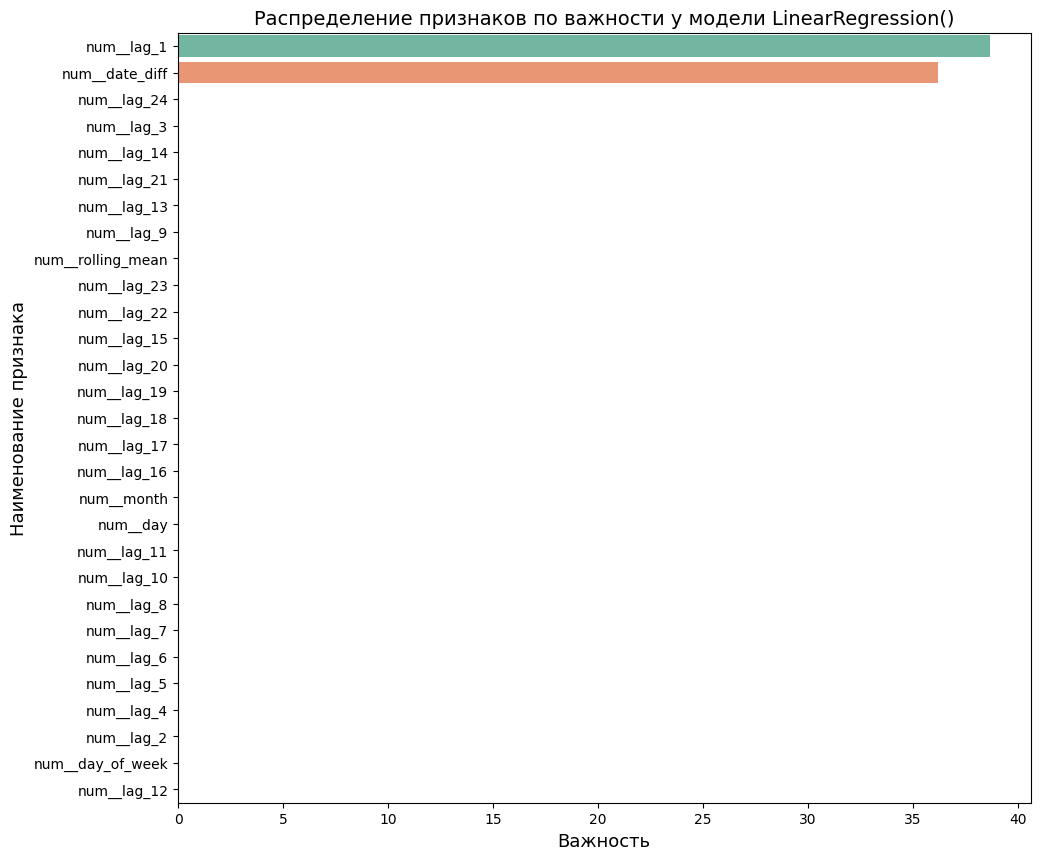

In [36]:
#создадим датафрейм с важностью признаков и отсортируем значения
feature_importance_trial = \
    pd.DataFrame({'Наименование признака': grid_search_trial.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),\
                  'Важность': np.abs(grid_search_trial.best_estimator_.named_steps['models'].coef_)})

#построим график
plt.figure(figsize=(11, 10))
ax = sns.barplot(x = 'Важность', y = 'Наименование признака' , \
                 data = feature_importance_trial.sort_values(by='Важность', ascending=False), palette = 'Set2')
plt.xlabel('Важность', fontsize = 13)
plt.ylabel('Наименование признака', fontsize = 13)
plt.title('Распределение признаков по важности у модели LinearRegression()', fontsize = 14)
plt.show()

**По графику важности признаков модели LinearRegression() видно следующее:**
- столбец со значением смещенного целевого признака на один шаг `lag_1` имеет наибольшую важность
- столбец со значениями разности временного ряда `date_diff` второй по важности  
- столбцы с календарными признаками, столбцы со смещениями целевого признака от 2 до 24 шагов и столбец со скользящим средним `rolling_mean` вообще не имеют важности для принятия решений моделью

**На втором этапе обучения моделей были проделаны следующие действия:**

- **в датафрейм, полученный на первом этапе, был дополнительно добавлен столбец с разностью временного ряда `date_diff`**
- данные были заново подготовлены и разбиты на тренировочную и тестовую выборку без перемешивания
- заново были обучены и подобраны гиперпараметры для точно таких же пяти моделей:

  - ***Модель LinearRegression() при разных наборах гиперпарметров показала лучший результат на втором этапе обучения среди всех моделей:***
   - ***метрика RMSE*** после добавления столбца с разностью временного ряда `date_diff` у лучшей модели LinearRegression() ***составила 4.155192e-14***, практически равна , прогноз был абсолютно точен, метрика отличается от нуля только по причине того, что в целевом признаке целочисленные значения, а в прогнозе значения с плавающей точкой.
   - лучший набор гиперпараметров оказался следующим: `'models__copy_X': False`, `'models__positive': True`, `'models__fit_intercept': True`, `'preprocessor__num': StandardScaler()`.
   - среднее время обучения составило 0.013 секунды
   - среднее время оценивания и прогноза составило 0.005 секунды
  - ***CatBoostRegressor*** ('iterations': 1200, 'learning_rate': 0.03, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 3.95***
  - ***LGBMRegressor*** (max_depth=6, n_estimators=1000, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 5.62***
  - ***DecisionTreeRegressor*** ('max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 12) ***улучшила метрику RMSE при кросс-валиации до 17.46***
  - ***KNeighborsRegressor*** ('n_neighbors': 9, 'num': 'passthrough') ***улучшила метрику RMSE при кросс-валиации до 20.69***
   
**График важности признаков лучшей модели LinearRegression() показывает следующее:**
- столбец со значением смещенного целевого признака на один шаг `lag_1` имеет наибольшую важность
- столбец со значениями разности временного ряда `date_diff` второй по важности  
- столбцы с календарными признаками, столбцы со смещениями целевого признака от 2 до 24 шагов и столбец со скользящим средним `rolling_mean` вообще не имеют важности для принятия решений моделью

## Тестирование

### Проверка на тестовых данных

Осталось проверить, что метрика не сильно ухудшается на тестовых данных. Сделаем прогноз с помощью лучшей модели LinearRegression(), полученной на втором этапе обучения, и посмотрим на итоговую метрику.

In [37]:
#время начала предсказания модели
start_pred = time.time()

# проверяем работу лучшей модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_rate_predict = grid_search_trial.predict(X_test_trial)


#полное время предсказания модели
preds_time = time.time() - start_pred

print(f'Прогнозное время модели: {preds_time:.4f}')

print(f'\nМетрика RMSE лучшей модели на тестовой выборке: {rmse_score(y_test_trial, y_test_rate_predict)}')

Прогнозное время модели: 0.0039

Метрика RMSE лучшей модели на тестовой выборке: 1.5520842781115072e-13


**Результаты лучшей модели LinearRegression() на тестовой выборке получились следующие:**
 - метрика RMSE = 1.5520842781115072e-13, прогнозные значения совпали с тестовыми.
 - прогнозное время составило 0.004 секунды

### Анализ остатков

Хоть в данном случае остатки будут состоять из разницы типов данных в целевом признаке (целочисленный тип) и в прогнозных значениях (с плавающей точкой), но этот график строим всегда после получения прогнозных значений на тесте. Не будем делать исключений в этот раз.

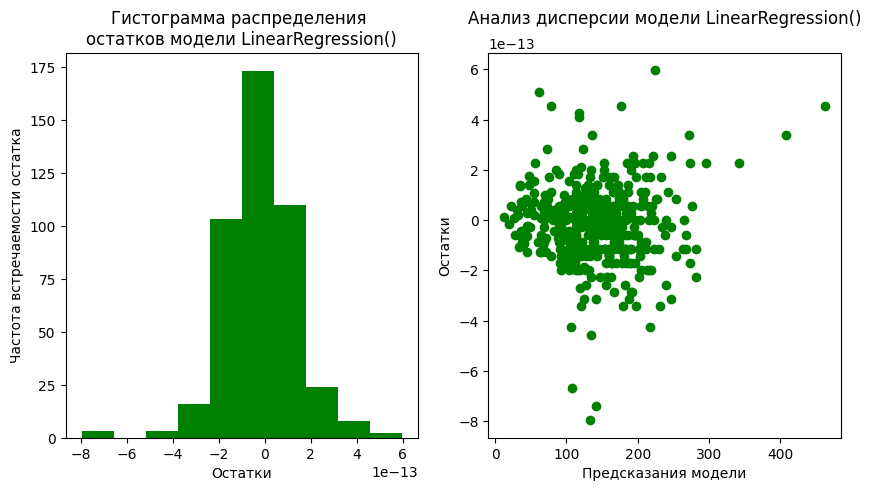

In [38]:
#проведем анализ остатков, посторим гистограмму распределения остатков и диаграмму рассеяния
residuals = y_test_trial - y_test_rate_predict

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=10, color = 'green')
axes[0].set_title('Гистограмма распределения \nостатков модели LinearRegression()')
axes[0].set_ylabel('Частота встречаемости остатка')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x = y_test_rate_predict, y = residuals, color = 'green')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии модели LinearRegression()\n')
plt.show()

**Полученные графики показывают следующее:**
- гистограмма показывает нормальное распределение остатков, стремящихся к нулю без перекосов
- дисперсия остатков равномерна на всем протяжении значений.

Осталось проверить модель на адекватность

### Проверка модели на адекватность

#### Проверка с результатами модели DummyRegressor()

Сравним результаты, предсказанные с помощью нашей лучшей модели, с результатами модели `DummyRegressor()`. Эта модель использует несколько типов стратегий, мы остановимся на той, когда всем прогнозным значениям присваивается медианное значение целевого признака

Объявим константную модель, в качестве стратегии укажем `median`. Обучим ее на тренировочном датасете, получим прогноз тестового датасета и сравним метрику RMSE у нее и у нашей лучшей модели. Для модели DummyRegressor() не будем подготавливать тренировочныее данные, так как она использует значения целевого признака для предсказания

In [39]:
#объявляем модель и указываем тип стратегии
dummy_model_regressor = DummyRegressor(strategy = 'median').fit(X_train, y_train)

#получаем прогнозные значения DummyRegressor()
dummy_regressor_predict = dummy_model_regressor.predict(X_test)
#считаем метрику RMSE и выводим ее, так как не используем кросс-валидацию, то используем непосредственно функцию rmse_score
print(f'Метрика RMSE Dummy модели на тестовой выборке: {rmse_score(y_test, dummy_regressor_predict)}')

Метрика RMSE Dummy модели на тестовой выборке: 87.15277582981295


**Наша лучшая модель справилась с проверкой на адекватность и показала метрику RMSE намного ниже, чем у константной модели DummyRegressor()**

#### Проверка на предыдущих значениях ряда

Также проверим результаты нашей лучшей модели по другой стратегии проверки качества. Предскажем значения для нашего целевого признака на тестовой выборке при помощи предыдущего значения временного ряда этой же выборки (размер шага для `shift` = 1) и оценим метрику RMSE у получившегося прогноза. Для первого значения из тестовой выборки сдвинутым на один шаг назад будет последнее значение из тренировочной выборки, поэтому при сдвиге укажем заполнение пропусков на последнее значение из целевого признака тренировочной выборки `fill_value=y_train.iloc[-1]`

In [40]:
#создадим массив со значениями предыдущего шага временного ряда
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print(f'Метрика RMSE у прогноза, основанного на предыдущем значении временного ряда: {rmse_score(pred_previous,y_test):.2f}')

Метрика RMSE у прогноза, основанного на предыдущем значении временного ряда: 58.86


**Наша лучшая модель справилась с проверкой на адекватность и показала метрику RMSE намного ниже, чем у прогноза, основанного на предыдущем значении временного ряда**

**На этапе тестирования были получены следующие результаты:**
 - метрика RMSE лучшей модели LinearRegression() на тестовой выборке составила 1.5520842781115072e-13
 - прогнозное время на тестовой выборке составило 0.004 секунды

**Полученные графики анализа остатков показывали следующее:**
- гистограмма показывает нормальное распределение остатков, стремящихся к нулю без перекосов
- дисперсия остатков равномерна на всем протяжении значений.

**Наша лучшая модель справилась с проверками на адекватность и показала метрику RMSE намного ниже, чем у:**
 - константной модели DummyRegressor()
 - прогноза, основанного на предыдущем значении временного ряда

## Итоговые выводы

**На этапе подготовки данных было проделано следующее:**
- загружен датасет и проведено первичное ознакомление:
   - датасет имеет размерность 26496 строк 
   - не имеет явных пропусков
   - столбцы имеют корректные типы данных
   - названия столбцов приведены к змеиному "регистру"
   - дубликатов не обнаружено
- датасет отсортирован по времени 
- произведено ресемплирование значений по одному часу

**На этапе анализа данных полученные графики позволили сделать следующие выводы:**
- отчетливо виден положительный тренд по увеличению общего кол-ва заказов на всем временном интервале с марта по август с еще большим увеличением кол-ва заказов в летний период. Так как мы рассматриваем данные за пол года, то в этом случае мы рассматриваем это увеличение, как тренд, если бы рассматривали более чем за 1 год и такое увеличение повторялось бы ежегодно, то это уже была бы сезонность.
- график сезонной составляющей показывает, что кол-во заказов такси с ночи до утра уменьшается, с утра до ночи увеличивается, пиковое количество заказов приходится ровно на полночь.
- также по графику сезонной составляющей видна цикличность в 24 часа.
- остатки распределены практически равномерно вокруг нуля. Присутствуют некоторые колебания, которые нам показывают, что есть выбросы с большим количеством заказов.
- тест Дики-Фуллера показал, что ряд стационарный
- по графику автокорреляции видно, что максимальное влияние оказывают 1 и 24 лаги.
- чаще всего в час бывает от 60 до 80 заказов
- кол-во заказов свыше 200 в час бывает редко

**Обучение моделей состояло из двух этапов, были проделаны следующие шаги и получены следующие результаты:**

**Первый этап обучения моделей включил следующее:**

- *Для обучения модели были созданы следующие входные признаки:*
   -  календарные (месяц, день, день недели)
   -  столбцы со сдвигом назад значений целевого признака временного ряда (максимальный сдвигаемый шаг - 24)
   -  столбец со скользящим средним (размер окна 24), так как скользящее среднее задает общий тренд временного ряда

- *Для новых входных признаков построена матрица корреляции для понимания влияния на целевой признак. Из полученной матрицы корреляции видно следующее:*
  - самая высокая корреляция между целевым признаком `num_orders` и столбцами со следующими сдвигами значений: 
     - `lag_24` (0.7),
     - `lag_2` (0.67),
     - `lag_1` (0.65),
     - `lag_23` (0.59)
     - и столбцом со скользящим средним `rolling_mean` 0.58
  - из календарных столбцов самая высокая корреляция с целевым признаком у столбца `month` - 0.44, у признака `day_of_week` самая низкая корреляция между всеми входными признаками - 0.076
  - мультиколлинеарности между новыми входными признаками не выявлено
   
- данные разделены на тренировочную и тестовую выборки без перемешивания значений и удалены пустые значения в тренировочной выборке, для которых нет исторических данных
- для оценивания качества работы моделей была созданна функция для расчета метрики RMSE, которая при помощи `make_scorer` была применена при автоматизированном поиске гиперпараметров

**Были обучены и подобраны гиперпараметры для пяти моделей:**
- *DecisionTreeRegressor():*
   - данные были масштабированы при помощи StandardScaler(), а лучшие гиперпараметры были подобраны при помощи OptunaSearchCV() за 4.91 секунды
   - лучшие гиперпараметры оказались следующими: *'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 12*
   - основные показатели получились следующими:
    - метрика RMSE при кросс-валидации составила 28.53 и оказалась худшей среди всех моделей
    - среднее время обучения 0.013 секунды
    - среднее время прогноза и оценивания 0.0012 секунды
   
- *KNeighborsRegressor(),*
- *LinearRegressor(),*
- *CatBoostRegressor(),*
- *LGBMRegressor():*
  - для этих четырех моделей для удобства подбора гиперпараметров был составлен общий пайплайн, включающий:
    - подготовку данных: масштабирование количественных признаков при помощи StandardScaler() и MinMaxScaler()
    - перебор гиперпараметров для моделей со словарями их гиперпараметров при помощи инструмента автоматизированного подбора GridSearchCV()
-полученные результаты при подборе гиперпараметров для этих 4 моделей позволили сделать следующие выводы:
- **лучшей моделью первого этапа обучения оказалась модель CatBoostRegressor(iterations = 1200, learning_rate = 0.03, depth = 6, StandardScaler()), метрика RMSE лучшей модели при кросс-валидации составила 23.3, среднее время обучения составило 3.315 секунды, а среднее время оценки и прогноза модели составило 0.007 секунды**
  - на втором месте оказалась модель LGBMRegressor() со стандартным набором гиперпараметров, метрика у нее оказалась немного хуже, чем у модели CatBoostRegressor(), а время обучения оказалось немного больше - 0.54 секунды, прогнозное время оказалось 0.0074 сек.
  - лучшая из моделей KNeighborsRegressor() оказалась на 3 месте из всех моделей, метрика RMSE -  24.24, но зато время обучения составило всего 0.001 секунды. Зато время прогнозирования и оценивания у CatBoostRegressor() в разы быстрее, чем у модели ближних соседей, а этот параметр важнее обучения.
  - модель DecisionTreeRegressor() показала худшую метрику при кросс-валидации среди всех моделей - 28.53 секунды.
    
**Полученный график важности признаков лучшей модели первого этапа обучения CatBoostRegressor() показал следующее:**
- прогнозируемая моделью величина кол-ва заказов больше всего зависит от столбца `lag_24`, в котором находятся смещенные на 24 шага назад значения из столбца с целевым признаком
- второе место по важности занимает столбец с признаком `lag_1`
- из столбцов с календарными признаками наибольшую важность занимает столбец `day_of_week`
- столбец со скользящим средним `rolling_mean` занимает предпоследнее место по важности признаков
- наименее важный признак - столбец с календарным признаком `day`

**Второй этап обучения моделей включил следующее:**

- **в датафрейм, полученный на первом этапе, был дополнительно добавлен столбец с разностью временного ряда `date_diff`**
- данные были заново подготовлены и разбиты на тренировочную и тестовую выборку без перемешивания
- заново были обучены и подобраны гиперпараметры для точно таких же пяти моделей:

  - ***Модель LinearRegression() при разных наборах гиперпарметров показала лучший результат на втором этапе обучения среди всех моделей:***
   - ***метрика RMSE*** после добавления столбца с разностью временного ряда `date_diff` у лучшей модели LinearRegression() ***составила 4.155192e-14***, практически равна 0, прогноз был абсолютно точен, метрика отличается от нуля только по причине того, что в целевом признаке целочисленные значения, а в прогнозе значения с плавающей точкой.
   - лучший набор гиперпараметров оказался следующим: `'models__copy_X': False`, `'models__positive': True`, `'models__fit_intercept': True`, `'preprocessor__num': StandardScaler()`.
   - среднее время обучения составило 0.013 секунды
   - среднее время оценивания и прогноза составило 0.005 секунды
  - ***CatBoostRegressor*** ('iterations': 1200, 'learning_rate': 0.03, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 3.95***
  - ***LGBMRegressor*** (max_depth=6, n_estimators=1000, 'num': StandardScaler()) ***улучшила метрику RMSE при кросс-валиации до 5.62***
  - ***DecisionTreeRegressor*** ('max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 12) ***улучшила метрику RMSE при кросс-валиации до 17.46***
  - ***KNeighborsRegressor*** ('n_neighbors': 9, 'num': 'passthrough') ***улучшила метрику RMSE при кросс-валиации до 20.69***
   
**График важности признаков лучшей модели LinearRegression() показал следующее:**
- столбец со значением смещенного целевого признака на один шаг `lag_1` имеет наибольшую важность
- столбец со значениями разности временного ряда `date_diff` второй по важности  
- столбцы с календарными признаками, столбцы со смещениями целевого признака от 2 до 24 шагов и столбец со скользящим средним `rolling_mean` вообще не имеют важности для принятия решений моделью

**На этапе тестирования были получены следующие результаты:**
 - метрика RMSE лучшей модели LinearRegression() на тестовой выборке составила 1.5520842781115072e-13, прогноз был абсолютно точен.
 - прогнозное время на тестовой выборке составило 0.004 секунды

**Полученные графики анализа остатков лучшей модели показали следующее:**
- гистограмма показывает нормальное распределение остатков, стремящихся к нулю без перекосов
- дисперсия остатков равномерна на всем протяжении значений.

**Наша лучшая модель справилась с проверками на адекватность и показала метрику RMSE намного ниже, чем у:**
 - константной модели DummyRegressor()
 - прогноза, основанного на предыдущем значении временного ряда